<a href="https://colab.research.google.com/github/emilychrystalyn/financial-risk-modelling/blob/main/Financial_Risk_Modelling_emily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.stats.diagnostic as dg

%matplotlib inline
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy import stats

from sklearn.preprocessing import StandardScaler

#**Data Preparation**

In [ ]:
data = pd.read_csv('/content/data_train_raw.csv')
data

,PERIOD,CUST_NAME,AREA_CODE,PAYMENT
0,1,CUST_253,AREA_2,0.003051
1,1,CUST_316,AREA_2,0.000104
2,1,CUST_354,AREA_2,0.000049
3,1,CUST_60,AREA_2,0.000490
4,1,CUST_193,AREA_2,0.000280
...,...,...,...,...
15545,42,CUST_450,AREA_2,0.000831
15546,42,CUST_172,AREA_2,0.000000
15547,42,CUST_405,AREA_1,0.000000
15548,42,CUST_171,AREA_2,0.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15550 entries, 0 to 15549
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PERIOD     15550 non-null  int64  
 1   CUST_NAME  15550 non-null  object 
 2   AREA_CODE  15550 non-null  object 
 3   PAYMENT    15550 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 486.1+ KB


In [ ]:
#Descriptive Statistics
data.describe()

,PERIOD,PAYMENT
count,15550.000000,15550.000000
mean,22.805595,0.002436
std,11.852436,0.013811
min,1.000000,0.000000
25%,13.000000,0.000000
50%,23.000000,0.000027
75%,33.000000,0.000322
max,42.000000,0.251533


#**Data Aggregation**

In [ ]:
#sum of payment per periodx
data2 = data.groupby(['PERIOD']).sum()
data2

,PAYMENT
PERIOD,
1,0.961027
2,0.960179
3,0.912805
4,0.901135
5,0.907304
6,0.903893
7,0.899354
8,0.890392
9,0.888938


In [ ]:
data2 = data2.rename({'PAYMENT':'PAYMENT_RATE'},axis=1)

In [ ]:
data2

,PAYMENT_RATE
PERIOD,
1,0.961027
2,0.960179
3,0.912805
4,0.901135
5,0.907304
6,0.903893
7,0.899354
8,0.890392
9,0.888938


In [ ]:
#LOSS_RATE = 1 - payment rate
data2=pd.DataFrame(data2)
data2['LOSS_RATE'] = 1 - data2['PAYMENT_RATE']
data2

,PAYMENT_RATE,LOSS_RATE
PERIOD,,
1,0.961027,0.038973
2,0.960179,0.039821
3,0.912805,0.087195
4,0.901135,0.098865
5,0.907304,0.092696
6,0.903893,0.096107
7,0.899354,0.100646
8,0.890392,0.109608
9,0.888938,0.111062


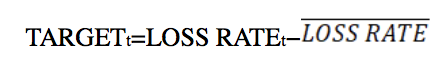

In [ ]:
#TARGET = LOSS_RATE at time t - Average of total LOSS RATE
data2['TARGET'] = data2['LOSS_RATE'] - data2['LOSS_RATE'].mean()
data2

,PAYMENT_RATE,LOSS_RATE,TARGET
PERIOD,,,
1,0.961027,0.038973,-0.059114
2,0.960179,0.039821,-0.058266
3,0.912805,0.087195,-0.010893
4,0.901135,0.098865,0.000778
5,0.907304,0.092696,-0.005391
6,0.903893,0.096107,-0.001980
7,0.899354,0.100646,0.002559
8,0.890392,0.109608,0.011520
9,0.888938,0.111062,0.012975


Merge data with data_train_features

In [ ]:
data_features = pd.read_csv('/content/data_train_features.csv')
data_features

,PERIOD,FEATURE_1,FEATURE_2,FEATURE_3
0,1,-4.109960,0.768639,-0.526741
1,2,-0.808078,0.726132,-0.838717
2,3,-0.155381,0.695734,-1.150692
3,4,0.305347,0.229346,-1.150692
4,5,1.610742,-0.102861,-1.150692
5,6,-1.204918,-0.351512,-1.150692
6,7,0.151771,-0.216423,-1.150692
7,8,0.382135,-0.019916,-1.150692
8,9,4.503189,0.292218,-1.150692
9,10,1.610742,0.288426,-1.150692


In [ ]:
data2.reset_index(inplace=True)
data2

,PERIOD,PAYMENT_RATE,LOSS_RATE,TARGET
0,1,0.961027,0.038973,-0.059114
1,2,0.960179,0.039821,-0.058266
2,3,0.912805,0.087195,-0.010893
3,4,0.901135,0.098865,0.000778
4,5,0.907304,0.092696,-0.005391
5,6,0.903893,0.096107,-0.001980
6,7,0.899354,0.100646,0.002559
7,8,0.890392,0.109608,0.011520
8,9,0.888938,0.111062,0.012975
9,10,0.889241,0.110759,0.012672


In [ ]:
finaldata = pd.merge(data2,data_features)
finaldata

,PERIOD,PAYMENT_RATE,LOSS_RATE,TARGET,FEATURE_1,FEATURE_2,FEATURE_3
0,1,0.961027,0.038973,-0.059114,-4.109960,0.768639,-0.526741
1,2,0.960179,0.039821,-0.058266,-0.808078,0.726132,-0.838717
2,3,0.912805,0.087195,-0.010893,-0.155381,0.695734,-1.150692
3,4,0.901135,0.098865,0.000778,0.305347,0.229346,-1.150692
4,5,0.907304,0.092696,-0.005391,1.610742,-0.102861,-1.150692
5,6,0.903893,0.096107,-0.001980,-1.204918,-0.351512,-1.150692
6,7,0.899354,0.100646,0.002559,0.151771,-0.216423,-1.150692
7,8,0.890392,0.109608,0.011520,0.382135,-0.019916,-1.150692
8,9,0.888938,0.111062,0.012975,4.503189,0.292218,-1.150692
9,10,0.889241,0.110759,0.012672,1.610742,0.288426,-1.150692


#**Exploratory Data Analysis**

In [ ]:
#Exploratory data analysis can be conducted using the raw and final train data. You are expected to produce statistical or visual analysis regarding these contexts: 

#Payment data distribution across period and area 
#Loss rate changes across time 


**Payment data distribution across area**

In [ ]:
area = data.groupby(['AREA_CODE'])[['PAYMENT']].mean()
area

,PAYMENT
AREA_CODE,
AREA_1,0.000006
AREA_2,0.002780


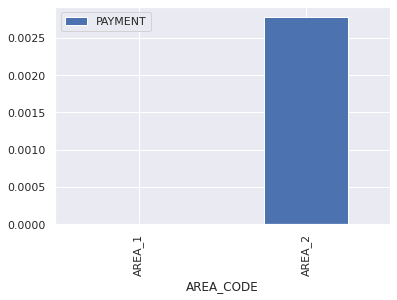

In [ ]:
area.plot.bar()

It can be seen that the comparison of the average payments in the two areas is very far, so the company must consider this in terms of payments in Area_1.

**Payment data distribution across period**

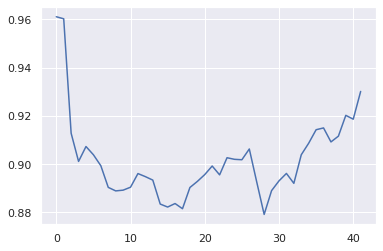

In [ ]:
#Payment Rate Trend
data2['PAYMENT_RATE'].plot.line()

In [ ]:
data2['PAYMENT_RATE'].mean()

0.9019127211173421

In [ ]:
# Mutate variables based on rate of calories

def PAYMENT_RATE(x):
  if x>=0.9019127211173421:
    return "High"
  else:
    return "Low"

data2["High_or_Low_PAYMENT_RATE"]= data2['PAYMENT_RATE'].apply(PAYMENT_RATE)
data2.head()

,PERIOD,PAYMENT_RATE,LOSS_RATE,TARGET,High_or_Low_PAYMENT_RATE
0,1,0.961027,0.038973,-0.059114,High
1,2,0.960179,0.039821,-0.058266,High
2,3,0.912805,0.087195,-0.010893,High
3,4,0.901135,0.098865,0.000778,Low
4,5,0.907304,0.092696,-0.005391,High


In [ ]:
payment_rate = data2.groupby(['High_or_Low_PAYMENT_RATE'])[['PERIOD']].count()
payment_rate

,PERIOD
High_or_Low_PAYMENT_RATE,
High,17
Low,25


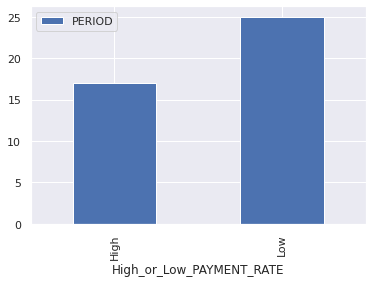

In [ ]:
payment_rate.plot.bar()

in terms of the payment rate, the rate that exceeds the average is only 40.47%, then the company must maximize the payment rate so that the loss rate also decreases

In [ ]:
col = "PAYMENT_RATE"
max_x1 = data2.loc[data2[col].idxmax()]
print (max_x1)

PERIOD                             1
PAYMENT_RATE                0.961027
LOSS_RATE                   0.038973
TARGET                     -0.059114
High_or_Low_PAYMENT_RATE        High
Name: 0, dtype: object


In [ ]:
col = "LOSS_RATE"
min_x1 = data2.loc[data2[col].idxmin()]
print (min_x1)

PERIOD                             1
PAYMENT_RATE                0.961027
LOSS_RATE                   0.038973
TARGET                     -0.059114
High_or_Low_PAYMENT_RATE        High
Name: 0, dtype: object


###**Period 1** has the best performance with the highest Payment Rate and lowest Loss Rate

In [ ]:
col = "PAYMENT_RATE"
min_x2 = data2.loc[data2[col].idxmin()]
print (min_x2)

PERIOD                            29
PAYMENT_RATE                  0.8792
LOSS_RATE                     0.1208
TARGET                      0.022713
High_or_Low_PAYMENT_RATE         Low
Name: 28, dtype: object


In [ ]:
col = "LOSS_RATE"
max_x2 = data2.loc[data2[col].idxmax()]
print (max_x2)

PERIOD                            29
PAYMENT_RATE                  0.8792
LOSS_RATE                     0.1208
TARGET                      0.022713
High_or_Low_PAYMENT_RATE         Low
Name: 28, dtype: object


###**Period 29** has the worst performance with the lowest Payment Rate and highest Loss Rate

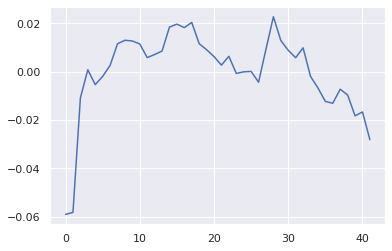

In [ ]:
#Target Rate Trend
data2['TARGET'].plot.line()

The plot of the payment rate is definitely inversely proportional to the loss rate

**Loss Changes Across Time**

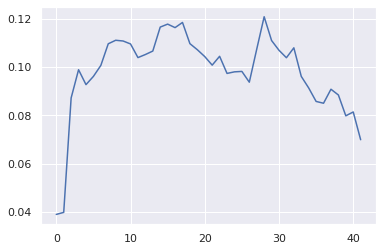

In [ ]:
#Loss Rate Trend
data2['LOSS_RATE'].plot.line()

It can be seen in the line plot of the loss rate above that in the period 30 to 40 there was a significant decrease in the loss rate. So we can conclude that the period of 30 and above has an improved payment rate. While in the first period of, the loss rate tend to increase significantly.

#**Data Preprocessing**

Data Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
scaleddata = rs.fit_transform(finaldata)

In [ ]:
finaldata_df = pd.DataFrame(scaleddata,
                              columns = finaldata.columns)
finaldata_df.head()

,PERIOD,PAYMENT_RATE,LOSS_RATE,TARGET,FEATURE_1,FEATURE_2,FEATURE_3
0,-1.000000,3.624434,-3.624434,-3.624434,-4.906977,2.114004,0.000000
1,-0.951220,3.575892,-3.575892,-3.575892,-0.906977,1.981560,-0.173913
2,-0.902439,0.864543,-0.864543,-0.864543,-0.116279,1.886841,-0.347826
3,-0.853659,0.196612,-0.196612,-0.196612,0.441860,0.433630,-0.347826
4,-0.804878,0.549678,-0.549678,-0.549678,2.023256,-0.601492,-0.347826


#**Regression Model Fitting using OLS (Ordinary Least Square)**

In [ ]:
finaldata_df

,PERIOD,PAYMENT_RATE,LOSS_RATE,TARGET,FEATURE_1,FEATURE_2,FEATURE_3
0,-1.000000,3.624434,-3.624434,-3.624434,-4.906977,2.114004,0.000000
1,-0.951220,3.575892,-3.575892,-3.575892,-0.906977,1.981560,-0.173913
2,-0.902439,0.864543,-0.864543,-0.864543,-0.116279,1.886841,-0.347826
3,-0.853659,0.196612,-0.196612,-0.196612,0.441860,0.433630,-0.347826
4,-0.804878,0.549678,-0.549678,-0.549678,2.023256,-0.601492,-0.347826
5,-0.756098,0.354476,-0.354476,-0.354476,-1.387721,-1.376259,-0.347826
6,-0.707317,0.094681,-0.094681,-0.094681,0.255814,-0.955338,-0.347826
7,-0.658537,-0.418221,0.418221,0.418221,0.534884,-0.343044,-0.347826
8,-0.609756,-0.501479,0.501479,0.501479,5.527256,0.629531,-0.347826
9,-0.560976,-0.484131,0.484131,0.484131,2.023256,0.617715,-0.347826


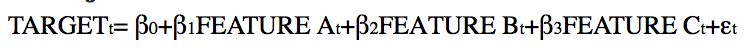

In [ ]:
X = sm.add_constant(finaldata_df[['FEATURE_1','FEATURE_2','FEATURE_3']].to_numpy()) 
y = finaldata_df['TARGET'].to_numpy()
LR = sm.OLS(y,X)
model1 = LR.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     22.91
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           1.23e-08
Time:                        04:08:36   Log-Likelihood:                -37.368
No. Observations:                  42   AIC:                             82.74
Df Residuals:                      38   BIC:                             89.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2595      0.099     -2.628      0.0

**Model Regression : Y = - 0.2595 + 0.3906X1 - 0.3305X2 + 1.1369X3**, The results of the following linear model explain the influence between the independent variable and the dependent variable, where X1 and X3 have a positive effect, but X2 has a negative effect on Y (Target).

Note that all of the variables X are significant with Y, because the p-value are less than (<) 0.05

When viewed from the adjusted r-squared, the model can only explain as much as 1 - 0.616% of the data, so some additional features/variables are still needed in order to get better model performance.

#**Classic Assumption Test for Regression**


1.   Normality Test
2.   Multicollinearity Test
3.   Heteroscedasticity Test
4.   Autocorrelation Test


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


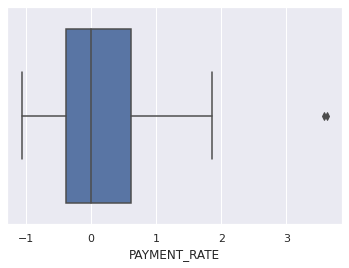

In [ ]:
sns.boxplot(finaldata_df['PAYMENT_RATE'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


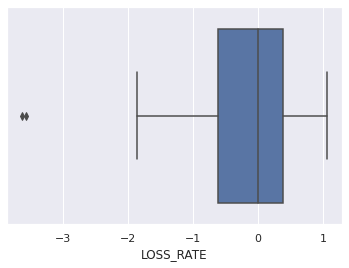

In [ ]:
sns.boxplot(finaldata_df['LOSS_RATE'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


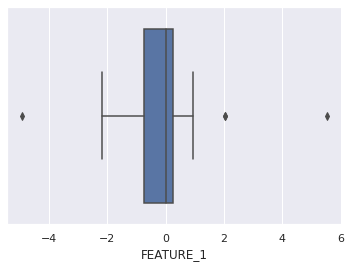

In [ ]:
sns.boxplot(finaldata_df['FEATURE_1'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


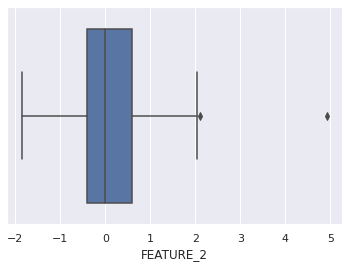

In [ ]:
sns.boxplot(finaldata_df['FEATURE_2'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


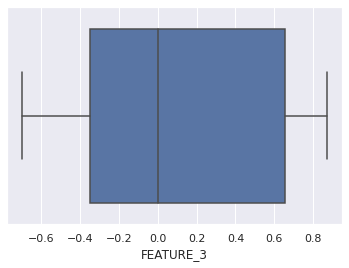

In [ ]:
sns.boxplot(finaldata_df['FEATURE_3'])

From the boxplot above, the height variable others are not looking skewed as distance of both whiskers are equal and hence normally distributed. And for more normality check, we plot the distribution :

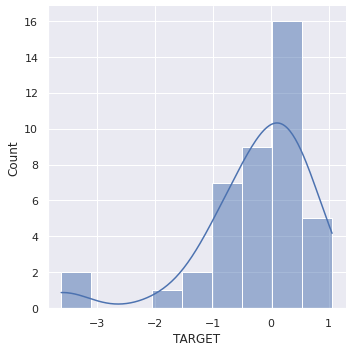

In [ ]:
# Distribusi TARGET
sns.displot(finaldata_df, x="TARGET",kde=True)

Although it has been tried in several ways, according to the histogram plot the distribution is still skewed to the left, so the normality test is not included, so it can be assumed that the data is not normal.

##Multicollinearity Test

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = finaldata[['FEATURE_1','FEATURE_2','FEATURE_3']]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Factor"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
 
print(vif_data)

      Factor       VIF
0  FEATURE_1  1.021405
1  FEATURE_2  1.008312
2  FEATURE_3  1.013355


All of the VIF of every independent variable (X) are less than 10, so we can conclude that there is no multicollinearity between the independent variables.

##Heteroscedasticity Test

In [ ]:
#perform Bresuch-Pagan test
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(model1.resid, model1.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 5.964374706001719),
 ('p-value', 0.11335639585251868),
 ('f-value', 2.0965016052768313),
 ('f p-value', 0.11683626868390402)]

The significance level (𝛼 = 0.05) is less than the p-value of each portfolio, thus the null hypothesis is accepted. This explains that homoscedasticity is present or the residuals are distributed with equal variance in each variables.

##Autocorrelation Test

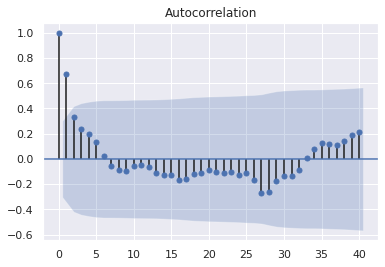

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(finaldata_df['TARGET'],lags=40)
plt.show()

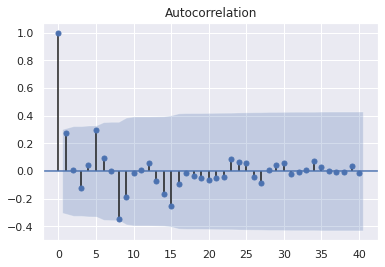

In [ ]:
plot_acf(finaldata_df['FEATURE_1'],lags=40)
plt.show()

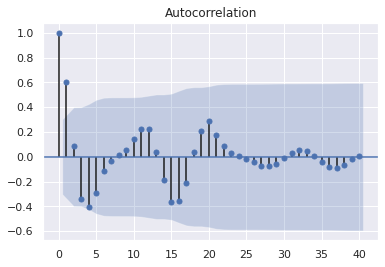

In [ ]:
plot_acf(finaldata_df['FEATURE_2'],lags=40)
plt.show()

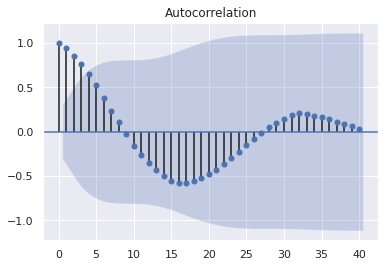

In [ ]:
plot_acf(finaldata_df['FEATURE_3'],lags=40)
plt.show()

According to the autocorrelation test, within the range in the confidence interval with a default value of α = 0.05 represents a value that has no significant correlation with the most recent value for the rate. The relationship between the current value of a variable and its past value is independent.

#**Model Evaluation**

**RMSE**

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(finaldata_df['TARGET'], finaldata['FEATURE_1'])) 

1.1119645415927542

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(finaldata_df['TARGET'], finaldata['FEATURE_2'])) 

1.2199037025309847

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(finaldata_df['TARGET'], finaldata['FEATURE_3'])) 

1.0086138546941161

It can be seen that the RMSE value of the target and feature data is classified as low. The smaller the RMSE, the better the model is able to fit the data. If we compare the RMSE values of the three feature data, the model that is able to adjust the data is Feature_3 which has the lowest RMSE value of 1.0086138546941161.

**Mean Absolute Percent Error (MAPE)**

In [ ]:
TARGET = finaldata_df['TARGET']
FEATURE_1 = finaldata_df['FEATURE_1']
FEATURE_2 = finaldata_df['FEATURE_2']
FEATURE_3 = finaldata_df['FEATURE_3']

In [ ]:
def MAPE(TARGET,FEATURE_1):
  TARGET,FEATURE_1 = np.array(TARGET) , np.array(FEATURE_1)
  MAPE = np.mean(np.abs((TARGET-FEATURE_1)/TARGET))*100
  return MAPE


In [ ]:
print("MAPE: ",MAPE(TARGET,FEATURE_1))

MAPE:  219.50487518295313


In [ ]:
def MAPE(TARGET,FEATURE_2):
  TARGET,FEATURE_2 = np.array(TARGET) , np.array(FEATURE_2)
  MAPE = np.mean(np.abs((TARGET-FEATURE_2)/TARGET))*100
  return MAPE


In [ ]:
print("MAPE: ",MAPE(TARGET,FEATURE_2))

MAPE:  323.3357225969894


In [ ]:
def MAPE(TARGET,FEATURE_3):
  TARGET,FEATURE_2 = np.array(TARGET) , np.array(FEATURE_3)
  MAPE = np.mean(np.abs((TARGET-FEATURE_3)/TARGET))*100
  return MAPE


In [ ]:
print("MAPE: ",MAPE(TARGET,FEATURE_3))

MAPE:  159.79150103056793


If we compare the MAPE values of the three feature data, the model with the lowest MAPE value is FEATURE_3, it can be concluded that the best model that is able to explain the TARGET data is FEATURE_3